In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [4]:
# download the datasets
letterdata = tv.datasets.EMNIST(root="../Datasets/", split="letters", download=True)
numberdata = tv.datasets.EMNIST(root="../Datasets/", split="digits", download=True)

In [7]:
# transformations on the letter data

# remove N/A class
letterCategories = letterdata.classes[1:]
labels = copy.deepcopy(letterdata.targets) - 1

# transform to 4D tensor for conv layers (and transform from int8 to float)
letterImages = letterdata.data.view([letterdata.data.shape[0], 1, 28, 28]).float()
letterImages /= torch.max(letterImages)


# split the images and convert to dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(
    letterImages, labels, test_size=0.1
)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize = 32
letter_train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device)
)
letter_test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], generator=torch.Generator(device=device))

In [8]:
### transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0], 1, 28, 28]).float()
numberImages /= torch.max(numberImages)


# split the images and convert to dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(
    numberImages, numberdata.targets, test_size=0.1
)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize = 32
number_train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device)
)
number_test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], generator=torch.Generator(device=device)), 

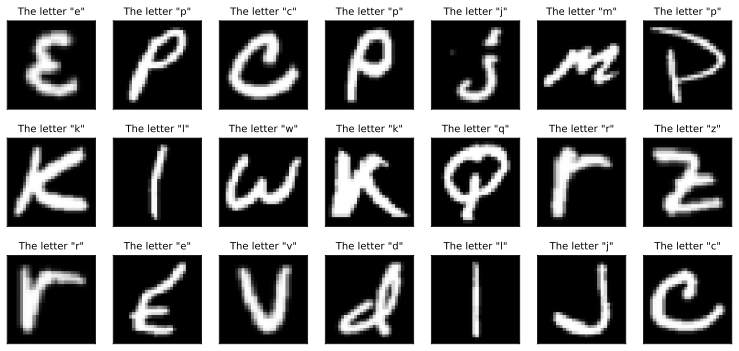

In [9]:
# visualize some letters
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

# get a batch of letter data
X, y = next(iter(letter_train_loader))

for i, ax in enumerate(axs.flatten()):

    # extract the image and its target letter
    I = np.squeeze(X[i, :, :])
    letter = letterCategories[y[i]]

    # visualize
    ax.imshow(I.T, cmap="gray", vmin=0, vmax=1)
    ax.set_title('The letter "%s"' % letter, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

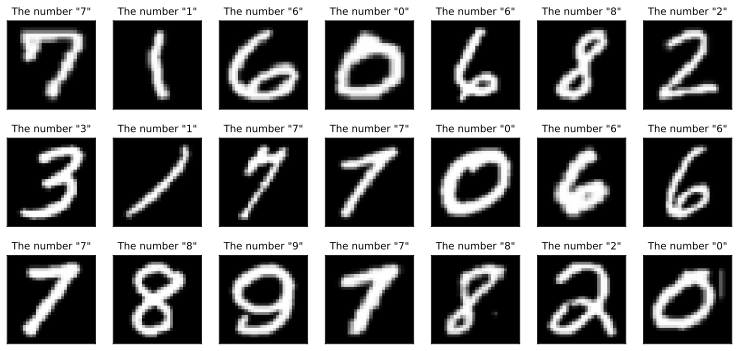

In [10]:
# visualize some numbers
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

# get a batch of number data
X, y = next(iter(number_train_loader))

for i, ax in enumerate(axs.flatten()):

    # extract the image and its target letter
    I = np.squeeze(X[i, :, :])
    number = y[i].item()

    # visualize
    ax.imshow(I.T, cmap="gray", vmin=0, vmax=1)
    ax.set_title('The number "%s"' % number, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [11]:
# Create the DL Model
# create a class for the model
def makeTheNet(printtoggle=False):

    class emnistnet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- feature map layers -------------- ###
            # first convolution layer
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(
                6
            )  # input the number of channels in this layer
            # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

            # second convolution layer
            self.conv2 = nn.Conv2d(6, 6, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(
                6
            )  # input the number of channels in this layer
            # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

            ### -------------- linear decision layers -------------- ###
            self.fc1 = nn.Linear(7 * 7 * 6, 50)
            self.fc2 = nn.Linear(50, 26)

        def forward(self, x):

            if self.print:
                print(f"Input: {list(x.shape)}")

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:
                print(f"Second CPR block: {list(x.shape)}")

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print:
                print(f"Final output: {list(x.shape)}")

            return x

    # create the model instance
    net = emnistnet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [13]:
# a function that trains the model


def function2trainTheModel(net, optimizer, train_loader, test_loader, numepochs=10):

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    testErr = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchLoss = []
        batchErr = []
        for X, y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and error from this batch
            batchLoss.append(loss.cpu().item())
            batchErr.append(
                torch.mean((torch.argmax(yHat, axis=1) != y).cpu().float()).item()
            )
        # end of batch loop...

        # and get average losses and error rates across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = 100 * np.mean(batchErr)

        ### test performance
        net.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():  # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat, y)

        # get loss and error rate from the test batch
        testLoss[epochi] = loss.cpu().item()
        testErr[epochi] = (
            100 * torch.mean((torch.argmax(yHat, axis=1) != y).cpu().float()).item()
        )

    # end epochs

    # function output
    return trainLoss, testLoss, trainErr, testErr, net

In [ ]:
# create a new model
letterNet, lossfun, optimizer = makeTheNet()

trainLoss, testLoss, trainErr, testErr, letterNet = function2trainTheModel(
    letterNet, optimizer, letter_train_loader, letter_test_loader, 5
)